In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/washington-building-label/building_label/1.4_buildings.png
/kaggle/input/washington-building-label/building_label/1.1_buildings.png
/kaggle/input/washington-building-label/building_label/1.3_buildings.png
/kaggle/input/washington-building-label/building_label/1.2_buildings.png
/kaggle/input/massachusetts-buildings-dataset/label_class_dict.csv
/kaggle/input/massachusetts-buildings-dataset/metadata.csv
/kaggle/input/massachusetts-buildings-dataset/tiff/val_labels/22978945_15.tif
/kaggle/input/massachusetts-buildings-dataset/tiff/val_labels/23728930_15.tif
/kaggle/input/massachusetts-buildings-dataset/tiff/val_labels/23429155_15.tif
/kaggle/input/massachusetts-buildings-dataset/tiff/val_labels/23579050_15.tif
/kaggle/input/massachusetts-buildings-dataset/tiff/test_labels/23429080_15.tif
/kaggle/input/massachusetts-buildings-dataset/tiff/test_labels/22829050_15.tif
/kaggle/input/massachusetts-buildings-dataset/tiff/test_labels/22828990_15.tif
/kaggle/input/massachusetts-build

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import albumentations as album
import segmentation_models_pytorch as smp

In [3]:
DATA_DIR = '/kaggle/input/massachusetts-buildings-dataset/png'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [4]:
class_dict = pd.read_csv("../input/massachusetts-buildings-dataset/label_class_dict.csv")
class_names = class_dict['name'].tolist()
class_rgb_values = class_dict[['r', 'g', 'b']].values.tolist()

In [5]:
select_classes = ['background', 'building']
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values = np.array(class_rgb_values)[select_class_indices]

In [6]:
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20, 8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(name.replace('_', ' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return semantic_map

def reverse_one_hot(image):
    x = np.argmax(image, axis=-1)
    return x

def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]
    return x

In [7]:
class BuildingsDataset(Dataset):
    def __init__(self, images_dir, masks_dir, class_rgb_values=None, augmentation=None, preprocessing=None):
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask
    
    def __len__(self):
        return len(self.image_paths)

In [8]:
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf([
            album.HorizontalFlip(p=1),
            album.VerticalFlip(p=1),
            album.RandomRotate90(p=1),
        ], p=0.75),
    ]
    return album.Compose(train_transform)

def get_validation_augmentation():
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=cv2.BORDER_CONSTANT, value=[0, 0, 0]),
    ]
    return album.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
    return album.Compose(_transform)


In [9]:
# class DoubleConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(DoubleConv, self).__init__()
#         self.double_conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#         )

#     def forward(self, x):
#         return self.double_conv(x)

# class DownBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(DownBlock, self).__init__()
#         self.double_conv = DoubleConv(in_channels, out_channels)
#         self.down_sample = nn.MaxPool2d(2)

#     def forward(self, x):
#         skip_out = self.double_conv(x)
#         down_out = self.down_sample(skip_out)
#         return (down_out, skip_out)

# class UpBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, up_sample_mode):
#         super(UpBlock, self).__init__()
#         if up_sample_mode == 'conv_transpose':
#             self.up_sample = nn.ConvTranspose2d(in_channels - out_channels, in_channels - out_channels, kernel_size=2, stride=2)
#         elif up_sample_mode == 'bilinear':
#             self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#         else:
#             raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
#         self.double_conv = DoubleConv(in_channels, out_channels)

#     def forward(self, down_input, skip_input):
#         x = self.up_sample(down_input)
#         x = torch.cat([x, skip_input], dim=1)
#         return self.double_conv(x)

# class UNet(nn.Module):
#     def __init__(self, out_classes=2, up_sample_mode='conv_transpose'):
#         super(UNet, self).__init__()
#         self.up_sample_mode = up_sample_mode
#         self.down_conv1 = DownBlock(3, 64)
#         self.down_conv2 = DownBlock(64, 128)
#         self.down_conv3 = DownBlock(128, 256)
#         self.down_conv4 = DownBlock(256, 512)
#         self.double_conv = DoubleConv(512, 1024)
#         self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
#         self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
#         self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
#         self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
#         self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

#     def forward(self, x):
#         x, skip1_out = self.down_conv1(x)
#         x, skip2_out = self.down_conv2(x)
#         x, skip3_out = self.down_conv3(x)
#         x, skip4_out = self.down_conv4(x)
#         x = self.double_conv(x)
#         x = self.up_conv4(x, skip4_out)
#         x = self.up_conv3(x, skip3_out)
#         x = self.up_conv2(x, skip2_out)
#         x = self.up_conv1(x, skip1_out)
#         x = self.conv_last(x)
#         return x

In [10]:

# Define download paths
download_path = "/kaggle/working/"

# URLs for pretrained models
model_urls = {
    'res2net50_v1b_26w_4s': 'https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net50_v1b_26w_4s-3cf99910.pth',
    'res2net101_v1b_26w_4s': 'https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net101_v1b_26w_4s-0812c246.pth',
}

# Download each model if not already present
for model_name, url in model_urls.items():
    model_file = os.path.join(download_path, f"{model_name}.pth")
    if not os.path.exists(model_file):
        print(f"Downloading {model_name}...")
        os.system(f"wget {url} -O {model_file}")
    else:
        print(f"{model_name} already exists.")

print("All models are ready.")


All models are ready.


In [11]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
import torch
import torch.nn.functional as F
__all__ = ['Res2Net', 'res2net50_v1b', 'res2net101_v1b']


model_urls = {
    'res2net50_v1b_26w_4s': 'https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net50_v1b_26w_4s-3cf99910.pth',
    'res2net101_v1b_26w_4s': 'https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net101_v1b_26w_4s-0812c246.pth',
}

model_files = {
    'res2net50_v1b_26w_4s': '/kaggle/working/res2net50_v1b_26w_4s.pth',
    'res2net101_v1b_26w_4s':'/kaggle/working/res2net101_v1b_26w_4s.pth'
}
class Bottle2neck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, baseWidth=26, scale = 4, stype='normal'):
        """ Constructor
        Args:
            inplanes: input channel dimensionality
            planes: output channel dimensionality
            stride: conv stride. Replaces pooling layer.
            downsample: None when stride = 1
            baseWidth: basic width of conv3x3
            scale: number of scale.
            type: 'normal': normal set. 'stage': first block of a new stage.
        """
        super(Bottle2neck, self).__init__()

        width = int(math.floor(planes * (baseWidth/64.0)))
        self.conv1 = nn.Conv2d(inplanes, width*scale, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width*scale)
        
        if scale == 1:
          self.nums = 1
        else:
          self.nums = scale -1
        if stype == 'stage':
            self.pool = nn.AvgPool2d(kernel_size=3, stride = stride, padding=1)
        convs = []
        bns = []
        for i in range(self.nums):
          convs.append(nn.Conv2d(width, width, kernel_size=3, stride = stride, padding=1, bias=False))
          bns.append(nn.BatchNorm2d(width))
        self.convs = nn.ModuleList(convs)
        self.bns = nn.ModuleList(bns)

        self.conv3 = nn.Conv2d(width*scale, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stype = stype
        self.scale = scale
        self.width  = width

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        spx = torch.split(out, self.width, 1)
        for i in range(self.nums):
          if i==0 or self.stype=='stage':
            sp = spx[i]
          else:
            sp = sp + spx[i]
          sp = self.convs[i](sp)
          sp = self.relu(self.bns[i](sp))
          if i==0:
            out = sp
          else:
            out = torch.cat((out, sp), 1)
        if self.scale != 1 and self.stype=='normal':
          out = torch.cat((out, spx[self.nums]),1)
        elif self.scale != 1 and self.stype=='stage':
          out = torch.cat((out, self.pool(spx[self.nums])),1)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
        
class DecoderBlock(nn.Module):
    def __init__(self,
                 in_channels=512,
                 n_filters=256,
                 kernel_size=3,
                 is_deconv=False,
                 ):
        super().__init__()
        if kernel_size == 3:
            conv_padding = 1
        elif kernel_size == 1:
            conv_padding = 0
        # B, C, H, W -> B, C/4, H, W
        self.conv1 = nn.Conv2d(in_channels,
                               in_channels // 4,
                               kernel_size,
                               padding=1,bias=False)
        self.norm1 = nn.BatchNorm2d(in_channels // 4)
        self.relu1 = nn.ReLU()
        # B, C/4, H, W -> B, C/4, H, W
        if is_deconv == True:
            self.deconv2 = nn.ConvTranspose2d(in_channels // 4,
                                              in_channels // 4,
                                              3,
                                              stride=2,
                                              padding=1,
                                              output_padding=conv_padding,bias=False)
        else:
            self.deconv2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.norm2 = nn.BatchNorm2d(in_channels // 4)
        self.relu2 = nn.ReLU()
        # B, C/4, H, W -> B, C, H, W
        self.conv3 = nn.Conv2d(in_channels // 4,
                               n_filters,
                               kernel_size,
                               padding=conv_padding,bias=False)
        self.norm3 = nn.BatchNorm2d(n_filters)
        self.relu3 = nn.ReLU()
    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.deconv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        return x
class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, bias=False)  # verify bias false
        self.bn = nn.BatchNorm2d(out_planes,
                                 eps=0.001,  # value found in tensorflow
                                 momentum=0.1,  # default pytorch value
                                 affine=True)
        self.relu = nn.ReLU(inplace=False)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class Res2_UNet(nn.Module):

    def __init__(self, block, layers, baseWidth = 26, scale = 4, num_classes=2):
        self.inplanes = 64
        super(Res2_UNet, self).__init__()
        self.baseWidth = baseWidth
        self.scale = scale
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 1, 1, bias=False)
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        #self.fc = nn.Linear(512 * block.expansion, num_classes)
        filters = [64, 128, 256, 512]
        is_deconv=False
        decoder_kernel_size=3
        self.base_size=512
        self.crop_size=512
        self._up_kwargs={'mode': 'bilinear', 'align_corners': True}
        # Decoder
        #in_channels=filters[3],
        self.center = DecoderBlock(in_channels=filters[3]*4,
                                   n_filters=filters[3],
                                   kernel_size=decoder_kernel_size,
                                   is_deconv=is_deconv)
        self.decoder4 = DecoderBlock(in_channels=filters[3] + filters[2]*4,
                                     n_filters=filters[2],
                                     kernel_size=decoder_kernel_size,
                                     is_deconv=is_deconv)
        self.decoder3 = DecoderBlock(in_channels=filters[2] + filters[1]*4,
                                     n_filters=filters[1],
                                     kernel_size=decoder_kernel_size,
                                     is_deconv=is_deconv)
        self.decoder2 = DecoderBlock(in_channels=filters[1] + filters[0]*4,
                                     n_filters=filters[0],
                                     kernel_size=decoder_kernel_size,
                                     is_deconv=is_deconv)
        self.decoder1 = DecoderBlock(in_channels=filters[0] + filters[0],
                                     n_filters=filters[0],
                                     kernel_size=decoder_kernel_size,
                                     is_deconv=is_deconv)
 
 
        self.finalconv = nn.Sequential(nn.Conv2d(filters[0], 32, 3, padding=1, bias=False),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU(),
                                       nn.Dropout2d(0.1, False),
                                       nn.Conv2d(32, num_classes, 1))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.AvgPool2d(kernel_size=stride, stride=stride, 
                    ceil_mode=True, count_include_pad=False),
                nn.Conv2d(self.inplanes, planes * block.expansion, 
                    kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample=downsample, 
                        stype='stage', baseWidth = self.baseWidth, scale=self.scale))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, baseWidth = self.baseWidth, scale=self.scale))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x_ = self.maxpool(x)

        x1 = self.layer1(x_)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        
        center = self.center(x4)
 
        d4 = self.decoder4(torch.cat([center, x3], 1))
        d3 = self.decoder3(torch.cat([d4, x2], 1))
        d2 = self.decoder2(torch.cat([d3, x1], 1))
        d1 = self.decoder1(torch.cat([d2, x], 1))
 
        f= self.finalconv(d1)
        #return tuple([f])

        return f


def load_pretrained_weights(model, model_name):
    """Load pretrained weights from local path if available."""
    if os.path.exists(model_files[model_name]):
        pretrained_dict = torch.load(model_files[model_name])
        net_dict = model.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in net_dict}
        net_dict.update(pretrained_dict)
        model.load_state_dict(net_dict)
    else:
        raise FileNotFoundError(f"{model_files[model_name]} not found. Please download the pretrained model.")

def res2net50_v1b(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b model."""
    model = Res2_UNet(Bottle2neck, [3, 4, 6, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        load_pretrained_weights(model, 'res2net50_v1b_26w_4s')
    return model

def res2net101_v1b(pretrained=False, **kwargs):
    """Constructs a Res2Net-101_v1b model."""
    model = Res2_UNet(Bottle2neck, [3, 4, 23, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        load_pretrained_weights(model, 'res2net101_v1b_26w_4s')
    return model

def res2net50_v1b_26w_4s(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s model."""
    model = Res2_UNet(Bottle2neck, [3, 4, 6, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        load_pretrained_weights(model, 'res2net50_v1b_26w_4s')
    return model

def res2net101_v1b_26w_4s(pretrained=False, **kwargs):
    """Constructs a Res2Net-101_v1b_26w_4s model."""
    model = Res2_UNet(Bottle2neck, [3, 4, 23, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        load_pretrained_weights(model, 'res2net101_v1b_26w_4s')
    return model

def res2net152_v1b_26w_4s(pretrained=False, **kwargs):
    """Constructs a Res2Net-152_v1b_26w_4s model."""
    model = Res2_UNet(Bottle2neck, [3, 8, 36, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        load_pretrained_weights(model, 'res2net152_v1b_26w_4s')  # Ensure the file exists
    return model






In [12]:
train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [13]:
class HybridLoss(nn.Module):
    def __init__(self):
        super(HybridLoss, self).__init__()
        self.dice_loss = smp.losses.DiceLoss(mode='multiclass')
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        targets = torch.argmax(targets, dim=1)  # Convert one-hot encoded target to class indices
        dice_loss = self.dice_loss(inputs, targets)
        ce_loss = self.ce_loss(inputs, targets.long())
        return dice_loss + ce_loss

# IoU metric
import segmentation_models_pytorch as smp

# Initialize the IoU metric from segmentation_models_pytorch
iou_metric = smp.utils.metrics.IoU(threshold=0.5)

# Function to calculate IoU using smp's IoU metric
def calculate_iou(outputs: torch.Tensor, labels: torch.Tensor):
    # Ensure outputs and labels are on the same device
    outputs, labels = outputs.cpu(), labels.cpu()
    
    # Apply the smp IoU metric
    iou_score = iou_metric(outputs, labels)
    
    # Return the IoU score
    return iou_score.item()



In [14]:


import segmentation_models_pytorch as smp
from tqdm import tqdm

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss function, optimizer, and learning rate scheduler
model = res2net50_v1b_26w_4s(pretrained=True).to(DEVICE)


loss_fn = HybridLoss()
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001)])
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)

# Define IoU metric with threshold
iou_metric = smp.utils.metrics.IoU(threshold=0.5)

# Function to calculate IoU using smp's IoU metric
def calculate_iou(outputs: torch.Tensor, labels: torch.Tensor):
    # Ensure outputs and labels are on the same device
    outputs, labels = outputs.cpu(), labels.cpu()
    # Apply the smp IoU metric
    iou_score = iou_metric(outputs, labels)
    # Return the IoU score
    return iou_score.item()

# Logging lists
train_logs_list = []
valid_logs_list = []

# Training loop
EPOCHS = 100
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    for images, masks in tqdm(train_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        
        # Accumulate loss and IoU for training
        running_loss += loss.item()
        running_iou += calculate_iou(outputs, masks)
    train_loss = running_loss / len(train_loader)
    train_iou = running_iou / len(train_loader)

    model.eval()
    running_loss = 0.0
    running_iou = 0.0
    with torch.no_grad():
        for images, masks in tqdm(valid_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            
            # Accumulate loss and IoU for validation
            running_loss += loss.item()
            running_iou += calculate_iou(outputs, masks)
    val_loss = running_loss / len(valid_loader)
    val_iou = running_iou / len(valid_loader)

    # Log results
    train_logs_list.append({'epoch': epoch + 1, 'train_loss': train_loss, 'train_iou': train_iou})
    valid_logs_list.append({'epoch': epoch + 1, 'valid_loss': val_loss, 'valid_iou': val_iou})
    
    print(f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")
    
    # Update learning rate
    lr_scheduler.step()


Epoch 1/100


100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


Train Loss: 1.7849, Train IoU: 0.2824
Val Loss: 7.6535, Val IoU: 0.2375
Epoch 2/100


100%|██████████| 4/4 [00:02<00:00,  1.72it/s]


Train Loss: 1.2256, Train IoU: 0.3530
Val Loss: 1.8344, Val IoU: 0.3329
Epoch 3/100


100%|██████████| 4/4 [00:02<00:00,  1.73it/s]


Train Loss: 1.0619, Train IoU: 0.3822
Val Loss: 1.0787, Val IoU: 0.3518
Epoch 4/100


100%|██████████| 4/4 [00:02<00:00,  1.69it/s]


Train Loss: 0.9444, Train IoU: 0.4065
Val Loss: 0.8945, Val IoU: 0.3863
Epoch 5/100


100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


Train Loss: 0.9096, Train IoU: 0.4316
Val Loss: 0.7812, Val IoU: 0.4250
Epoch 6/100


100%|██████████| 4/4 [00:02<00:00,  1.66it/s]


Train Loss: 0.8297, Train IoU: 0.4557
Val Loss: 0.7258, Val IoU: 0.4528
Epoch 7/100


100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


Train Loss: 0.8284, Train IoU: 0.4881
Val Loss: 0.6732, Val IoU: 0.4721
Epoch 8/100


100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Train Loss: 0.7548, Train IoU: 0.4871
Val Loss: 0.6424, Val IoU: 0.4839
Epoch 9/100


100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Train Loss: 0.7364, Train IoU: 0.5248
Val Loss: 0.6105, Val IoU: 0.5070
Epoch 10/100


100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Train Loss: 0.7046, Train IoU: 0.5420
Val Loss: 0.5751, Val IoU: 0.5505
Epoch 11/100


100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Train Loss: 0.6335, Train IoU: 0.5717
Val Loss: 0.5451, Val IoU: 0.5458
Epoch 12/100


100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Train Loss: 0.6307, Train IoU: 0.6059
Val Loss: 0.5274, Val IoU: 0.5518
Epoch 13/100


100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


Train Loss: 0.6487, Train IoU: 0.5805
Val Loss: 0.5116, Val IoU: 0.5663
Epoch 14/100


100%|██████████| 4/4 [00:02<00:00,  1.46it/s]


Train Loss: 0.5833, Train IoU: 0.6162
Val Loss: 0.5054, Val IoU: 0.5753
Epoch 15/100


100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Train Loss: 0.6160, Train IoU: 0.6047
Val Loss: 0.5003, Val IoU: 0.5601
Epoch 16/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.5888, Train IoU: 0.6079
Val Loss: 0.4964, Val IoU: 0.5625
Epoch 17/100


100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


Train Loss: 0.5984, Train IoU: 0.6110
Val Loss: 0.4875, Val IoU: 0.5775
Epoch 18/100


100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


Train Loss: 0.5714, Train IoU: 0.6203
Val Loss: 0.4836, Val IoU: 0.5893
Epoch 19/100


100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


Train Loss: 0.5602, Train IoU: 0.6326
Val Loss: 0.4679, Val IoU: 0.6001
Epoch 20/100


100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


Train Loss: 0.5462, Train IoU: 0.6584
Val Loss: 0.4623, Val IoU: 0.6217
Epoch 21/100


100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


Train Loss: 0.5240, Train IoU: 0.6637
Val Loss: 0.4558, Val IoU: 0.6256
Epoch 22/100


100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


Train Loss: 0.5299, Train IoU: 0.6606
Val Loss: 0.4443, Val IoU: 0.6399
Epoch 23/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.5247, Train IoU: 0.6915
Val Loss: 0.4369, Val IoU: 0.6552
Epoch 24/100


100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


Train Loss: 0.5047, Train IoU: 0.6818
Val Loss: 0.4352, Val IoU: 0.6489
Epoch 25/100


100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


Train Loss: 0.5087, Train IoU: 0.6843
Val Loss: 0.4312, Val IoU: 0.6407
Epoch 26/100


100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


Train Loss: 0.5204, Train IoU: 0.6940
Val Loss: 0.4271, Val IoU: 0.6445
Epoch 27/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.4905, Train IoU: 0.6825
Val Loss: 0.4323, Val IoU: 0.6393
Epoch 28/100


100%|██████████| 4/4 [00:02<00:00,  1.46it/s]


Train Loss: 0.4909, Train IoU: 0.7150
Val Loss: 0.4263, Val IoU: 0.6474
Epoch 29/100


100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Train Loss: 0.4990, Train IoU: 0.6973
Val Loss: 0.4224, Val IoU: 0.6253
Epoch 30/100


100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Train Loss: 0.4955, Train IoU: 0.7129
Val Loss: 0.4233, Val IoU: 0.6496
Epoch 31/100


100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Train Loss: 0.4859, Train IoU: 0.7119
Val Loss: 0.4257, Val IoU: 0.6651
Epoch 32/100


100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Train Loss: 0.5120, Train IoU: 0.7072
Val Loss: 0.4196, Val IoU: 0.6228
Epoch 33/100


100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


Train Loss: 0.4675, Train IoU: 0.7233
Val Loss: 0.4206, Val IoU: 0.6552
Epoch 34/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.4836, Train IoU: 0.7224
Val Loss: 0.4128, Val IoU: 0.6406
Epoch 35/100


100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


Train Loss: 0.4832, Train IoU: 0.7163
Val Loss: 0.4107, Val IoU: 0.6300
Epoch 36/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.4645, Train IoU: 0.7217
Val Loss: 0.4108, Val IoU: 0.6634
Epoch 37/100


100%|██████████| 4/4 [00:02<00:00,  1.47it/s]


Train Loss: 0.4784, Train IoU: 0.7273
Val Loss: 0.4005, Val IoU: 0.6526
Epoch 38/100


100%|██████████| 4/4 [00:02<00:00,  1.47it/s]


Train Loss: 0.4682, Train IoU: 0.7265
Val Loss: 0.4054, Val IoU: 0.6608
Epoch 39/100


100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


Train Loss: 0.4599, Train IoU: 0.7278
Val Loss: 0.4070, Val IoU: 0.6698
Epoch 40/100


100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


Train Loss: 0.4817, Train IoU: 0.7367
Val Loss: 0.4014, Val IoU: 0.6694
Epoch 41/100


100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


Train Loss: 0.4678, Train IoU: 0.7381
Val Loss: 0.3934, Val IoU: 0.6825
Epoch 42/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.4690, Train IoU: 0.7315
Val Loss: 0.3918, Val IoU: 0.6795
Epoch 43/100


100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


Train Loss: 0.4438, Train IoU: 0.7534
Val Loss: 0.3888, Val IoU: 0.6736
Epoch 44/100


100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Train Loss: 0.4631, Train IoU: 0.7422
Val Loss: 0.3819, Val IoU: 0.6600
Epoch 45/100


100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Train Loss: 0.4560, Train IoU: 0.7407
Val Loss: 0.3835, Val IoU: 0.6422
Epoch 46/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.4501, Train IoU: 0.7517
Val Loss: 0.3761, Val IoU: 0.6443
Epoch 47/100


100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


Train Loss: 0.4610, Train IoU: 0.7364
Val Loss: 0.3841, Val IoU: 0.6687
Epoch 48/100


100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


Train Loss: 0.4545, Train IoU: 0.7421
Val Loss: 0.3851, Val IoU: 0.6603
Epoch 49/100


100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Train Loss: 0.4147, Train IoU: 0.7427
Val Loss: 0.3783, Val IoU: 0.6749
Epoch 50/100


100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Train Loss: 0.4474, Train IoU: 0.7348
Val Loss: 0.3799, Val IoU: 0.6692
Epoch 51/100


100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Train Loss: 0.4702, Train IoU: 0.7344
Val Loss: 0.3815, Val IoU: 0.6754
Epoch 52/100


100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


Train Loss: 0.4409, Train IoU: 0.7621
Val Loss: 0.3795, Val IoU: 0.6684
Epoch 53/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.4482, Train IoU: 0.7393
Val Loss: 0.4055, Val IoU: 0.6872
Epoch 54/100


100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


Train Loss: 0.4455, Train IoU: 0.7497
Val Loss: 0.4230, Val IoU: 0.6918
Epoch 55/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.4462, Train IoU: 0.7533
Val Loss: 0.3810, Val IoU: 0.6909
Epoch 56/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.4890, Train IoU: 0.7333
Val Loss: 0.3726, Val IoU: 0.6795
Epoch 57/100


100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Train Loss: 0.4398, Train IoU: 0.7467
Val Loss: 0.3729, Val IoU: 0.6896
Epoch 58/100


100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


Train Loss: 0.4438, Train IoU: 0.7554
Val Loss: 0.3787, Val IoU: 0.6907
Epoch 59/100


100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


Train Loss: 0.4249, Train IoU: 0.7642
Val Loss: 0.3714, Val IoU: 0.6831
Epoch 60/100


100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Train Loss: 0.4322, Train IoU: 0.7612
Val Loss: 0.3731, Val IoU: 0.6678
Epoch 61/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.4287, Train IoU: 0.7521
Val Loss: 0.3709, Val IoU: 0.6648
Epoch 62/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.4219, Train IoU: 0.7528
Val Loss: 0.3710, Val IoU: 0.6596
Epoch 63/100


100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


Train Loss: 0.4551, Train IoU: 0.7474
Val Loss: 0.3658, Val IoU: 0.6631
Epoch 64/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.4429, Train IoU: 0.7536
Val Loss: 0.3647, Val IoU: 0.6930
Epoch 65/100


100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


Train Loss: 0.4296, Train IoU: 0.7611
Val Loss: 0.3640, Val IoU: 0.7188
Epoch 66/100


100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Train Loss: 0.4271, Train IoU: 0.7716
Val Loss: 0.3687, Val IoU: 0.7165
Epoch 67/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.3913, Train IoU: 0.7831
Val Loss: 0.3758, Val IoU: 0.7115
Epoch 68/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.4427, Train IoU: 0.7780
Val Loss: 0.3698, Val IoU: 0.7118
Epoch 69/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.4286, Train IoU: 0.7712
Val Loss: 0.3670, Val IoU: 0.7066
Epoch 70/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.4383, Train IoU: 0.7665
Val Loss: 0.3741, Val IoU: 0.6832
Epoch 71/100


100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Train Loss: 0.4294, Train IoU: 0.7716
Val Loss: 0.3787, Val IoU: 0.6548
Epoch 72/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.4179, Train IoU: 0.7474
Val Loss: 0.3826, Val IoU: 0.6323
Epoch 73/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.3950, Train IoU: 0.7662
Val Loss: 0.3730, Val IoU: 0.6226
Epoch 74/100


100%|██████████| 4/4 [00:02<00:00,  1.47it/s]


Train Loss: 0.4408, Train IoU: 0.7600
Val Loss: 0.3638, Val IoU: 0.6425
Epoch 75/100


100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Train Loss: 0.4667, Train IoU: 0.7562
Val Loss: 0.3600, Val IoU: 0.6545
Epoch 76/100


100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


Train Loss: 0.4116, Train IoU: 0.7616
Val Loss: 0.3634, Val IoU: 0.6413
Epoch 77/100


100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


Train Loss: 0.4131, Train IoU: 0.7495
Val Loss: 0.3675, Val IoU: 0.6475
Epoch 78/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.4161, Train IoU: 0.7603
Val Loss: 0.3644, Val IoU: 0.6467
Epoch 79/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.4289, Train IoU: 0.7783
Val Loss: 0.3571, Val IoU: 0.6536
Epoch 80/100


100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


Train Loss: 0.4129, Train IoU: 0.7711
Val Loss: 0.3604, Val IoU: 0.6550
Epoch 81/100


100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


Train Loss: 0.4231, Train IoU: 0.7615
Val Loss: 0.3624, Val IoU: 0.6789
Epoch 82/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.4407, Train IoU: 0.7492
Val Loss: 0.3637, Val IoU: 0.6800
Epoch 83/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.3939, Train IoU: 0.7823
Val Loss: 0.3556, Val IoU: 0.7122
Epoch 84/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.4023, Train IoU: 0.7774
Val Loss: 0.3621, Val IoU: 0.7242
Epoch 85/100


100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


Train Loss: 0.4080, Train IoU: 0.7627
Val Loss: 0.3668, Val IoU: 0.7251
Epoch 86/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.4585, Train IoU: 0.7633
Val Loss: 0.3663, Val IoU: 0.7045
Epoch 87/100


100%|██████████| 4/4 [00:02<00:00,  1.46it/s]


Train Loss: 0.4348, Train IoU: 0.7717
Val Loss: 0.3573, Val IoU: 0.7004
Epoch 88/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.3923, Train IoU: 0.7711
Val Loss: 0.3565, Val IoU: 0.6994
Epoch 89/100


100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Train Loss: 0.4252, Train IoU: 0.7598
Val Loss: 0.3524, Val IoU: 0.6777
Epoch 90/100


100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Train Loss: 0.3997, Train IoU: 0.7566
Val Loss: 0.3497, Val IoU: 0.6774
Epoch 91/100


100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Train Loss: 0.4104, Train IoU: 0.7581
Val Loss: 0.3531, Val IoU: 0.6640
Epoch 92/100


100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


Train Loss: 0.3848, Train IoU: 0.7533
Val Loss: 0.3505, Val IoU: 0.6660
Epoch 93/100


100%|██████████| 4/4 [00:02<00:00,  1.47it/s]


Train Loss: 0.4145, Train IoU: 0.7703
Val Loss: 0.3558, Val IoU: 0.6538
Epoch 94/100


100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Train Loss: 0.3729, Train IoU: 0.7803
Val Loss: 0.3488, Val IoU: 0.6779
Epoch 95/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.4042, Train IoU: 0.7666
Val Loss: 0.3511, Val IoU: 0.6757
Epoch 96/100


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Train Loss: 0.4011, Train IoU: 0.7691
Val Loss: 0.3467, Val IoU: 0.6769
Epoch 97/100


100%|██████████| 4/4 [00:02<00:00,  1.47it/s]


Train Loss: 0.4009, Train IoU: 0.7527
Val Loss: 0.3527, Val IoU: 0.6690
Epoch 98/100


100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


Train Loss: 0.4094, Train IoU: 0.7677
Val Loss: 0.3567, Val IoU: 0.6825
Epoch 99/100


100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Train Loss: 0.3831, Train IoU: 0.7714
Val Loss: 0.3516, Val IoU: 0.6832
Epoch 100/100


100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

Train Loss: 0.4014, Train IoU: 0.7707
Val Loss: 0.3479, Val IoU: 0.6827


In [15]:
# Define test dataset and dataloader
test_dataset = BuildingsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# Function to evaluate model on test data
def evaluate_model(model, dataloader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    running_iou = 0.0
    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            running_loss += loss.item()
            running_iou += calculate_iou(outputs, masks)  # Using smp's IoU metric with threshold
    epoch_loss = running_loss / len(dataloader)
    epoch_iou = running_iou / len(dataloader)
    return epoch_loss, epoch_iou

# Evaluate model on test data
test_loss, test_iou = evaluate_model(model, test_dataloader, loss_fn, DEVICE)
print(f"Evaluation on Test Data: Mean IoU Score: {test_iou:.4f}, Mean Dice Loss: {test_loss:.4f}")


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]

Evaluation on Test Data: Mean IoU Score: 0.7138, Mean Dice Loss: 0.3820


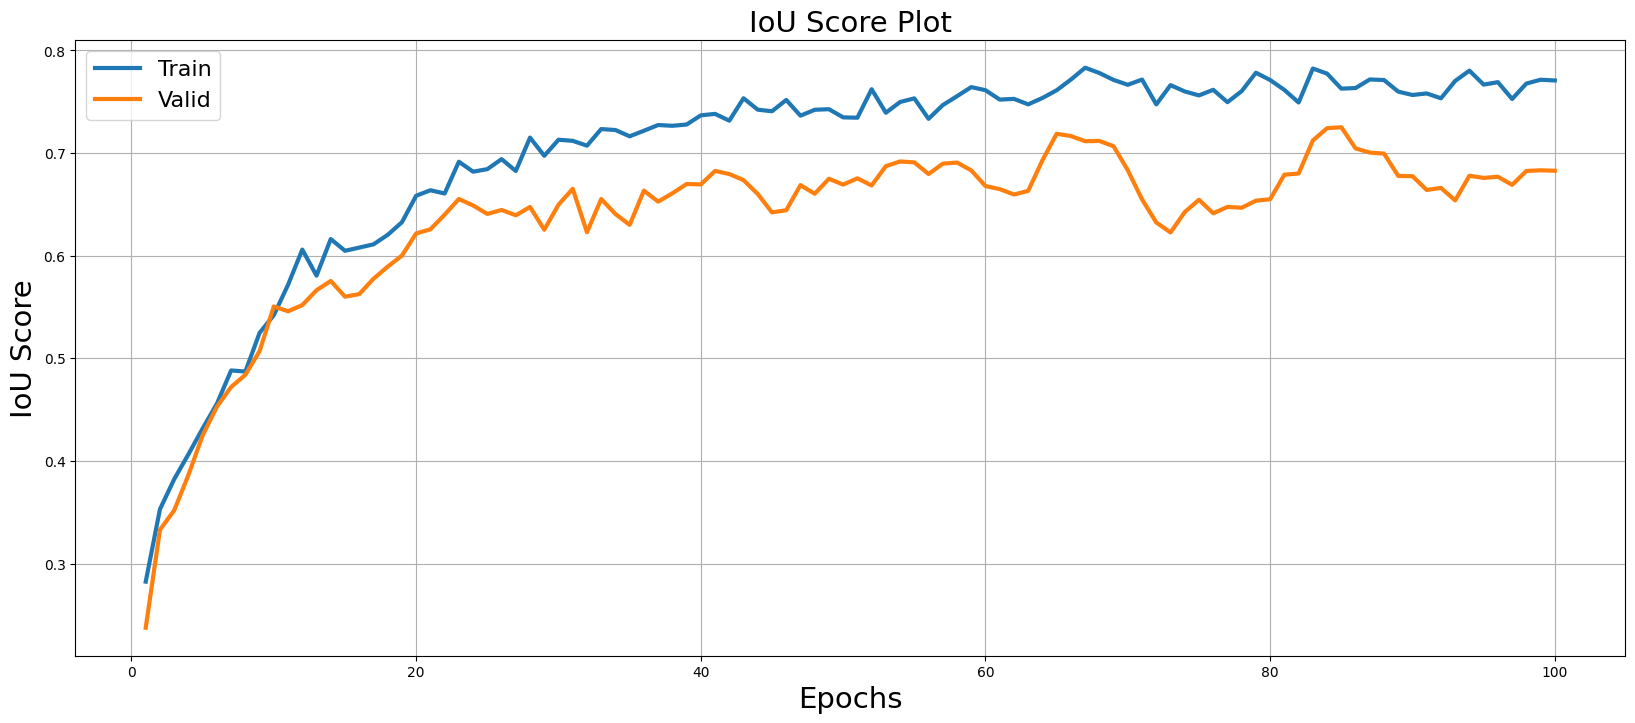

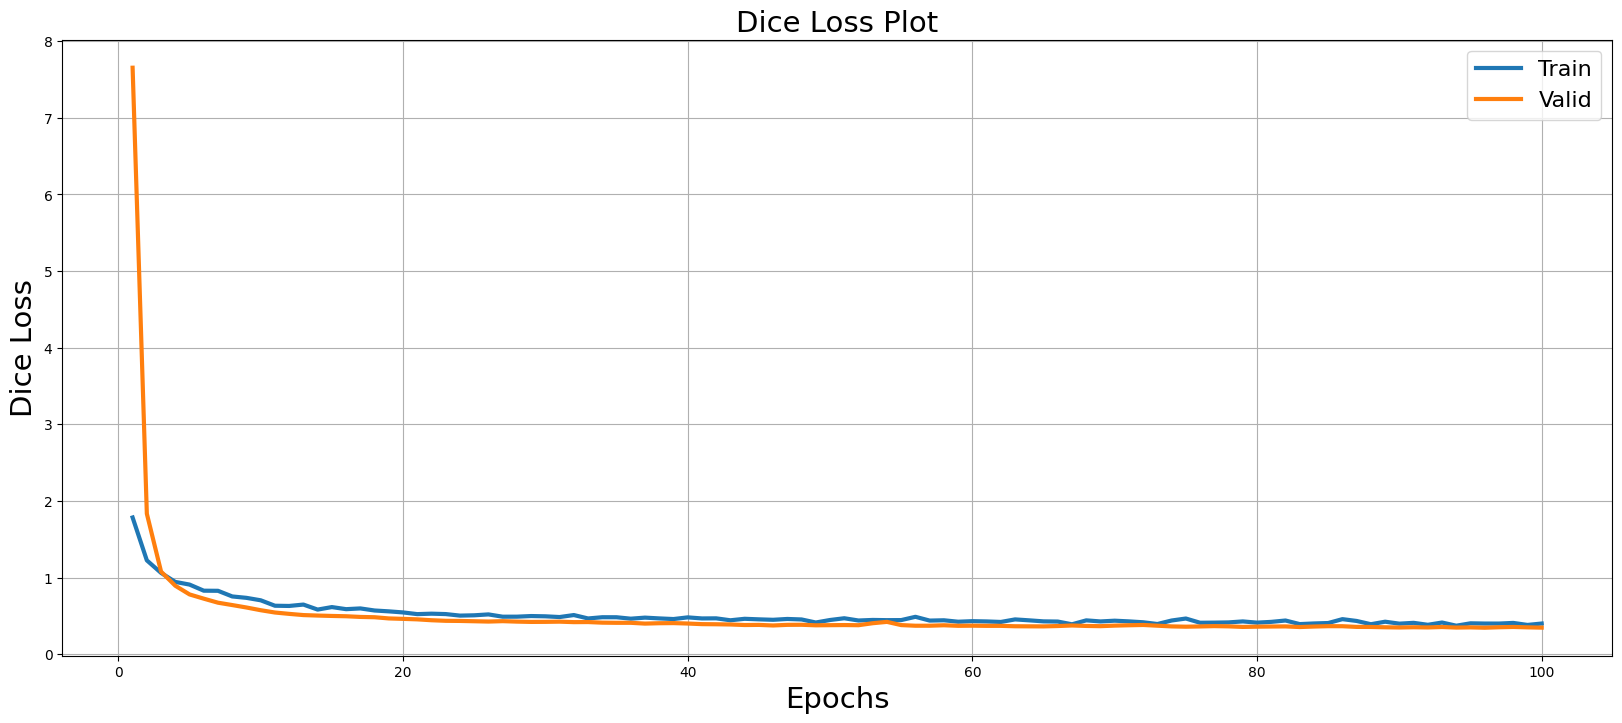

In [16]:
# Visualization of metrics
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)

plt.figure(figsize=(20, 8))
plt.plot(train_logs_df['epoch'], train_logs_df['train_iou'], lw=3, label='Train')
plt.plot(valid_logs_df['epoch'], valid_logs_df['valid_iou'], lw=3, label='Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('IoU Score', fontsize=21)
plt.title('IoU Score Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(train_logs_df['epoch'], train_logs_df['train_loss'], lw=3, label='Train')
plt.plot(valid_logs_df['epoch'], valid_logs_df['valid_loss'], lw=3, label='Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('Dice Loss', fontsize=21)
plt.title('Dice Loss Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()

In [17]:
def save_predictions(model, dataloader, device, class_rgb_values, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    
    with torch.no_grad():
        for i, (images, masks) in enumerate(tqdm(dataloader, desc="Saving Predictions")):
            images = images.to(device)
            outputs = model(images)
            predicted_masks = outputs.cpu().numpy()
            
            # Convert predictions to RGB format
            predicted_masks = np.argmax(predicted_masks, axis=1)
            decoded_preds = [colour_code_segmentation(mask, class_rgb_values) for mask in predicted_masks]
            
            for j, decoded_pred in enumerate(decoded_preds):
                # Convert to uint8 format
                decoded_pred = decoded_pred.astype(np.uint8)
                
                # Save each prediction as an image
                save_path = os.path.join(save_dir, f'pred_{i * len(decoded_preds) + j}.png')
                cv2.imwrite(save_path, cv2.cvtColor(decoded_pred, cv2.COLOR_RGB2BGR))

# Specify the directory for saving predictions
predictions_dir = './predictions'
save_predictions(model, test_dataloader, DEVICE, select_class_rgb_values, predictions_dir)


Saving Predictions: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


In [20]:
DATA_DIR_2 = '../input/sat_images'

x_test_dir_2 = '../input/washington-buildingsubset/'
y_test_dir_2 = '../input/washingtonsubset-buildings/test_labels/'

def resizeHelper(diry, output_dir, resolution):
    os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists

    for image_id in sorted(os.listdir(diry)):
        input_path = os.path.join(diry, image_id)
        output_path = os.path.join(output_dir, image_id)  # Preserve filename
        
        img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
        if img is None:
            print(f"Skipping {image_id} (could not read)")
            continue

        img_resized = cv2.resize(img, resolution, interpolation=cv2.INTER_AREA)
        cv2.imwrite(output_path, img_resized)
        print(f"Saved: {output_path}")

resizeHelper(x_test_dir_2, "./resizedImages", (1500, 1500))
resizeHelper(y_test_dir_2, "./resizedLabels", (1500, 1500))

xt2_final = "./resizedImages"
yt2_final = "./resizedLabels"

Saved: ./resizedImages/OUTPUT_1_1.png
Saved: ./resizedImages/OUTPUT_1_2.png
Saved: ./resizedImages/OUTPUT_1_3.png
Saved: ./resizedImages/OUTPUT_1_4.png
Saved: ./resizedImages/OUTPUT_2_1.png
Saved: ./resizedImages/OUTPUT_2_2.png
Saved: ./resizedImages/OUTPUT_2_3.png
Saved: ./resizedImages/OUTPUT_2_4.png
Saved: ./resizedLabels/1.1_buildings.png
Saved: ./resizedLabels/1.2_buildings.png
Saved: ./resizedLabels/1.3_buildings.png
Saved: ./resizedLabels/1.4_buildings.png
Saved: ./resizedLabels/2.1_buildings.png
Saved: ./resizedLabels/2.2_buildings.png
Saved: ./resizedLabels/2.3_buildings.png
Saved: ./resizedLabels/2.4_buildings.png


In [21]:
xt2_final = "./resizedImages"
yt2_final = "./resizedLabels"

test_dataset_2 = BuildingsDataset(
    xt2_final, 
    yt2_final, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

print([os.path.join("./resizedImages", image_id) for image_id in sorted(os.listdir('./resizedImages'))])

test_dataloader_2 = DataLoader(test_dataset_2)

['./resizedImages/OUTPUT_1_1.png', './resizedImages/OUTPUT_1_2.png', './resizedImages/OUTPUT_1_3.png', './resizedImages/OUTPUT_1_4.png', './resizedImages/OUTPUT_2_1.png', './resizedImages/OUTPUT_2_2.png', './resizedImages/OUTPUT_2_3.png', './resizedImages/OUTPUT_2_4.png']


In [22]:
test_loss, test_iou = evaluate_model(model, test_dataloader_2, loss_fn, DEVICE)
print(f"Evaluation on Test Data: Mean IoU Score: {test_iou:.4f}, Mean Dice Loss: {test_loss:.4f}")

predictions_dir_2 = './predictions_2'
save_predictions(model, test_dataloader_2, DEVICE, select_class_rgb_values, predictions_dir_2)

100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


Evaluation on Test Data: Mean IoU Score: 0.4349, Mean Dice Loss: 0.8906


Saving Predictions: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]
